In [1]:
from __future__ import division

In [471]:
import pandas as pd
import pandas_profiling

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [470]:
# read the csv file as a dataframe
df = pd.read_csv("Data+for+TreefortBnB+Puzzle.csv")

In [472]:
# take a quick look at the first few rows to check that everything looks OK
df.head()

,Unique id,City,State,$ Price,# of Reviews
0,1,Portland,OR,75,5
1,2,San Diego,CA,95,3
2,3,New York,NY,149,37
3,4,Los Angeles,CA,199,45
4,5,Denver,CO,56,99


In [473]:
# some sanity checks, these should all print zero

# how many rows have a state that isn't exactly two letters?
print(len(df[df.apply(lambda x : len(x['State']) != 2, axis=1)]))

0


In [474]:
# how many rows have a city that doesn't start with a capital letter?
print(len(df[df.apply(lambda x : x['City'][0].islower(), axis=1)]))

2


In [475]:
# oh dear, let's find the offending cities
df[df.apply(lambda x : x['City'][0].islower(), axis=1)]

,Unique id,City,State,$ Price,# of Reviews
33811,33812,miami,FL,275,0
42605,42606,new york,NY,187,0


In [476]:
# and fix them
df.loc[df['City'] == 'miami', 'City'] = 'Miami'
df.loc[df['City'] == 'new york', 'City'] = 'New York'

In [477]:
# are there any cities that are "accidentally" in uppercase too?
df[df.apply(lambda x : x['City'].isupper(), axis=1)]

,Unique id,City,State,$ Price,# of Reviews
5891,5892,LONG ISLAND CITY,NY,115,3


In [478]:
# fix it
df.loc[df['City'] == 'LONG ISLAND CITY', 'City'] = 'Long Island City'

In [479]:
# I'm going to assume up front that cities won't be unique i.e. we'll have the same city name in different states, so let's create a combined column
df['city_name'] = df.apply(lambda x : x['City'] + ', ' + x['State'], axis=1)

# just out of interest, how many unique city names are there?
print(df['City'].nunique())

# and how many actual cities?
print(df['city_name'].nunique())

# quite a few more :-)

103
125


In [498]:
# OK, first let's get the 100 top cities

# count how many times each city appears in the table
city_counts = df['city_name'].value_counts()

# grab the names of the cities and turn into a list of strings
top_100_cities = list(city_counts[0:100].index)

# look at the top ten cities
city_counts[:10]

New York, NY         8044
Brooklyn, NY         4368
San Francisco, CA    3622
Los Angeles, CA      3236
Austin, TX           2836
Washington, DC       1402
Miami Beach, FL      1345
Chicago, IL          1255
San Diego, CA         986
New Orleans, LA       833
Name: city_name, dtype: int64

In [499]:
# the cities that only have one listing are automatically suspect, so let's check the names manually
city_counts[city_counts == 1]

Durham, CA        1
Richmond, IL      1
Paris, TX         1
Hollywood, SC     1
Berkeley, CO      1
Richmond, TX      1
Long Beach, NJ    1
Madison, CT       1
Phoenix, MD       1
Pasadena, MD      1
Oakland, MD       1
Dallas, OR        1
Name: city_name, dtype: int64

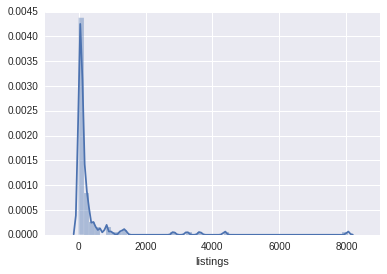

In [500]:
# look at a quick histogram of number of listings
c = city_counts.to_frame(name='listings')
c['city_name'] = c.index
sns.distplot(c['listings'])

# long-tailed, as we'd expect

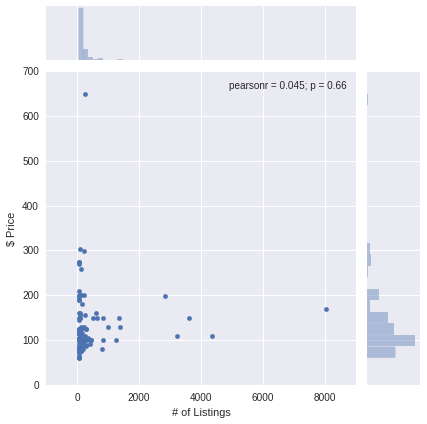

In [505]:
# now filter the table to include just the top 100 cities
just_top_100 = df[df['city_name'].isin(top_100_cities)]

# group the original data by city, grab the price, and calculate the median
median_prices = just_top_100.groupby('city_name', as_index=False).median()[['city_name', '$ Price']]

# it would be good to also know the number of listings
number_of_listings = just_top_100.groupby('city_name', as_index=False).count()[['city_name', 'City']]
number_of_listings.columns = ['city_name', '# of Listings']

# join these two columns together and sort high -> low and output csv
median_prices.sort_values('$ Price', ascending=False).to_csv("medians.csv", index = False)

# let's take a look at the data
city_data = number_of_listings.merge(median_prices, on="city_name").sort_values('$ Price', ascending=False)

# take a quick look at the joint distribution
# no strong correlation between number of listings and median price
sns.jointplot(x="# of Listings", y="$ Price", data=city_data)

In [506]:
# hmm, one very obvious outlier in price. look at the most expensive
city_data[:10]

,city_name,# of Listings,$ Price
35,"Indianapolis, IN",251,650.0
46,"Malibu, CA",92,304.0
65,"Park City, UT",229,299.0
29,"Healdsburg, CA",49,275.0
95,"Truckee, NV",67,275.0
39,"Laguna Beach, CA",68,268.5
34,"Incline Village, NV",118,259.0
47,"Manhattan Beach, CA",55,209.0
18,"Charlotte, NC",225,200.0
91,"Sonoma, CA",115,200.0


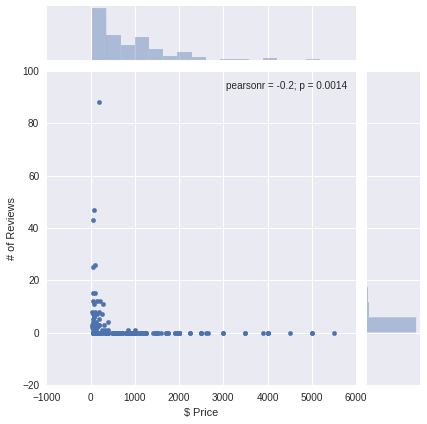

In [513]:
# hmm, Indianapolis definitely looks like an outlier, let's take a look at the original data
just_indianapolis = df[df['city_name'] == 'Indianapolis, IN']
sns.jointplot(x="$ Price", y="# of Reviews", data=just_indianapolis)

In [516]:
# looks like there are a bunch of expensive listings with no reviews
just_indianapolis[just_indianapolis['# of Reviews'] == 0].sort_values("$ Price", ascending=False)

,Unique id,City,State,$ Price,# of Reviews,city_name
8638,8639,Indianapolis,IN,5500,0,"Indianapolis, IN"
8856,8857,Indianapolis,IN,5000,0,"Indianapolis, IN"
9282,9283,Indianapolis,IN,5000,0,"Indianapolis, IN"
8674,8675,Indianapolis,IN,4500,0,"Indianapolis, IN"
9214,9215,Indianapolis,IN,4000,0,"Indianapolis, IN"
9204,9205,Indianapolis,IN,4000,0,"Indianapolis, IN"
8807,8808,Indianapolis,IN,3999,0,"Indianapolis, IN"
9443,9444,Indianapolis,IN,3900,0,"Indianapolis, IN"
6332,6333,Indianapolis,IN,3500,0,"Indianapolis, IN"
9279,9280,Indianapolis,IN,3500,0,"Indianapolis, IN"


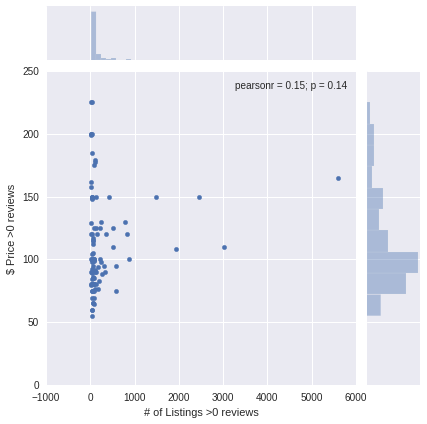

In [524]:
# looks like someone in Indianapolis is throwing up a bunch of super-expensive listings to make theirs seem more reasonable
# let's try again but just include the listings with at least one review

one_review = df[df['# of Reviews'] > 0]

just_top_100_one_review = one_review[one_review['city_name'].isin(top_100_cities)]

median_prices_one_review = just_top_100_one_review.groupby('city_name', as_index=False).median()[['city_name', '$ Price']]
median_prices_one_review.columns = ['city_name', '$ Price >0 reviews']

number_of_listings_one_review = just_top_100_one_review.groupby('city_name', as_index=False).count()[['city_name', 'City']]
number_of_listings_one_review.columns = ['city_name', '# of Listings >0 reviews']

# add these to the original table and sort again
lots_of_info = number_of_listings.merge(median_prices, on="city_name").merge(median_prices_one_review, on="city_name").merge(number_of_listings_one_review, on="city_name")
sns.jointplot(x="# of Listings >0 reviews", y="$ Price >0 reviews", data=lots_of_info)

In [525]:
# that looks more reasonable, output another csv file
lots_of_info[['city_name', '$ Price >0 reviews']].sort_values('$ Price >0 reviews', ascending=False).to_csv("medians_one_review.csv", index = False)

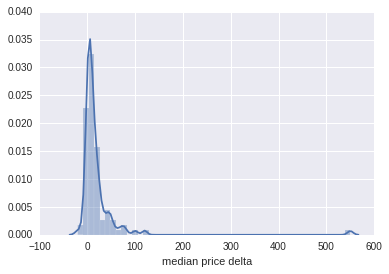

In [527]:
# looks like median price for listings with at least one review is always lower
# this makes sense, but let's check the delta:

lots_of_info['median price delta'] = lots_of_info.apply(lambda x : x['$ Price'] - x['$ Price >0 reviews'], axis=1)
sns.distplot(lots_of_info['median price delta'])

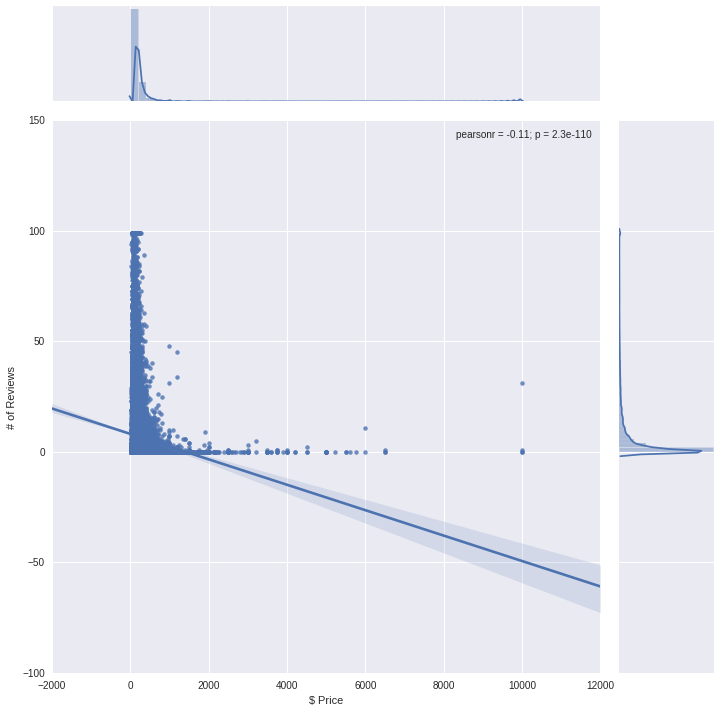

In [528]:
# ok, seems like no other city has a big a price difference as Indianapolis, so probably all good

# What's the general relationship between price and number of reviews?
sns.jointplot(y="# of Reviews", x= "$ Price", data=df, kind='reg', size=10)

In [529]:
#convincingly negative, as expected. Let's look at some outliers
# what are these 10000 listings?

df[df['$ Price'] == 10000]
# we need to look in a bit more detail at 2819, review padding?


,Unique id,City,State,$ Price,# of Reviews,city_name
2819,2820,San Francisco,CA,10000,31,"San Francisco, CA"
8867,8868,Park City,UT,10000,1,"Park City, UT"
26232,26233,Park City,UT,10000,0,"Park City, UT"
28626,28627,Miami Beach,FL,10000,0,"Miami Beach, FL"


In [532]:
import json

# now for some fun with maps
# we want to colour the states by median price, but we'll need to first figure out what states are actually represented

by_state = df.groupby('State', as_index=False).median()[['State', '$ Price']]
valid_states = list(by_state['State'])

by_state_one_review = one_review.groupby('State', as_index=False).median()[['State', '$ Price']]
valid_states_one_review = list(by_state_one_review['State'])

# we'll create custom geojson strings for the states that only contain the ones we want
states = json.loads(open('us-states.json').read())

print(str(len(states['features'])) + " states in the geojson file") 
for state in list(states['features']):
    state_code = state['id']
    if state_code not in valid_states:
        states['features'].remove(state)
print(str(len(states['features'])) + " states with at least one listing")


states_one_review = json.loads(open('us-states.json').read())

for state in list(states_one_review['features']):
    state_code = state['id']
    if state_code not in valid_states_one_review:
        states_one_review['features'].remove(state)
print(str(len(states_one_review['features'])) + " with at least one listing with at least one review")

50 states in the geojson file
34 states with at least one listing
33 with at least one listing with at least one review


In [567]:
import folium
import pandas as pd

# first let's colour the states by median price
# we can see that IN is way high due to all those fake Indianapolis listings with 0 reviews
map = folium.Map(location=[35, -102], zoom_start=4)
map.choropleth(geo_str=states, data=by_state,
             columns=['State', '$ Price'],
             key_on='feature.id',
            threshold_scale=[0, 100, 200, 300, 400, 500],
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Median price')

map.save("states_median_price.html")
#map
# hint: you can zoom/pan

In [568]:
# let's do the same but just for listings with at least one review
# looks much better, note squeezed scale

map = folium.Map(location=[35, -102], zoom_start=4)
map.choropleth(geo_str=states_one_review, data=by_state_one_review,
             columns=['State', '$ Price'],
             key_on='feature.id',
            threshold_scale=range(60, 150, 20),
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Median price')
map.save("state_median_price_one_review.html")
#map

In [ ]:
from geopy.geocoders import Nominatim

# we'd like to look at the city level, but we don't have location data so we need to look it up
# let's build a dict mapping cities to locations using the openstreetmap geocoding api
# this will avoid us having to look up the location for the same city multiple times

geolocator = Nominatim()
city2location = {}
for city in set(df['city_name']):
    print(city)
    city2location[city] = geolocator.geocode(city)

In [546]:
# use the coordinates lookup table to add lat/long columns to the table
df['lat'] = df.apply(lambda x : city2location[x['city_name']].latitude, axis=1)
df['long'] = df.apply(lambda x : city2location[x['city_name']].longitude, axis=1)


In [569]:
# let's try a heat map. red == more listings

from folium import plugins

locations = zip(list(df['lat']), list(df['long']))

map = folium.Map(location=[35, -102], zoom_start=4)
map.add_children(plugins.HeatMap(locations))

map.save("listings_heatmap.html")
#map

# this is kind of cool; as you zoom in the heatmap gets more fine grained

In [571]:
# let's do a city visualization
# take the by-city table and add locations

by_city = df.groupby('city_name', as_index=False).median()
number_of_listings = df.groupby('city_name', as_index=False).count()[['city_name', 'City']]
number_of_listings.columns = ['city_name', '# of Listings']
by_city = by_city.merge(number_of_listings, on="city_name")


map = folium.Map(location=[35, -102], zoom_start=4)

# now plot markers (click for city names and numbers of listings)
for each in by_city.iterrows(): 
    popup = each[1]['city_name'] + " : " + str(each[1]['# of Listings']) + " listings"
    marker = folium.Marker([each[1]['lat'], each[1]['long']], popup=popup)
    map.add_children(marker)
map.save("cities_popup.html")
#map

In [572]:
import math
import matplotlib
import matplotlib.cm as cm

# finally, a more ambitions visualization
# draw cities as circles
# area is number of listings, colour is median price (darker == more expensive)

# skip Indianapolis this time as it throws the colour scale out
not_indianapolis = by_city[by_city['city_name'] != 'Indianapolis, IN']

# set up a colour map for the median price
norm = matplotlib.colors.Normalize(vmin=not_indianapolis['$ Price'].min(), vmax=not_indianapolis['$ Price'].max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.OrRd)

map = folium.Map(location=[35, -102], zoom_start=4)


for each in not_indianapolis.iterrows(): 
    city = each[1]
    popup = city['city_name'] + " : " + str(city['# of Listings']) + " listings"
    fill = mapper.to_rgba(city['$ Price'])
    fill_hex = matplotlib.colors.rgb2hex(fill)
    
    marker = folium.CircleMarker(
        [city['lat'], city['long']], 
        radius = math.sqrt(city['# of Listings'] * 10000000),
        popup=popup,
        fill_opacity=0.9,
        color = "00000000",
        fill_color = fill_hex
    )
    map.add_children(marker)
map.save("cities_circles.html")
#map


In [566]:
df[df['city_name'] == 'Anchorage, AK']['$ Price'].median()

123.5